# Adding Multiple Wells

This notebook shows how a WellModel can be used to fit multiple wells with one response function. The influence of the individual wells is scaled by the distance to the observation point. 

**Authors**
- _R.A. Collenteur, Artesia Water 2018_
- _D.A. Brakenhoff, Artesia Water 2019_

Import the requisite modules

In [1]:
import numpy as np
import pandas as pd
import pastas as ps

ps.show_versions()

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) 
[Clang 9.0.1 ]
Numpy version: 1.17.5
Scipy version: 1.4.1
Pandas version: 0.25.0
Pastas version: 0.14.0b


## Load data from Menyanthes file

In [2]:
fname = '../data/MenyanthesTest.men'
meny = ps.read.MenyData(fname)

Get the heads

In [3]:
H = meny.H['Obsevation well']

## Create a model

Create a model with the heads timeseries and add recharge as a stress

In [4]:
ml = ps.Model(ps.TimeSeries(H['values'], name="heads"))

INFO: Cannot determine frequency of series heads


Get the precipitation and evaporation timeseries and round the index to remove the hours from the timestamps.

In [5]:
IN = meny.IN['Precipitation']['values']
IN.index = IN.index.round("D")
IN.name = "prec"
IN2 = meny.IN['Evaporation']['values']
IN2.index = IN2.index.round("D")
IN2.name = "evap"

Create a recharge stressmodel and add to the model

In [6]:
sm = ps.StressModel2([IN, IN2], ps.Gamma, 'Recharge')
ml.add_stressmodel(sm)

INFO: Inferred frequency from time series prec: freq=D 
INFO: Inferred frequency from time series evap: freq=D 


Get the extraction timeseries and add name to the series.

In [7]:
stresses = [ps.TimeSeries(meny.IN['Extraction 1']["values"], name="Extraction 1"),
            ps.TimeSeries(meny.IN['Extraction 2']["values"], name="Extraction 2"),
            ps.TimeSeries(meny.IN['Extraction 3']["values"], name="Extraction 3")]

INFO: Cannot determine frequency of series Extraction 1
INFO: Cannot determine frequency of series Extraction 2
INFO: Cannot determine frequency of series Extraction 3


Get the distances of the extractions to the observation well

In [8]:
# Get distances from metadata
xo = meny.H["Obsevation well"]['xcoord']
yo = meny.H["Obsevation well"]['ycoord']
distances = []
for extr in ['Extraction 1', 'Extraction 2', 'Extraction 3']:
    xw = meny.IN[extr]["xcoord"]
    yw = meny.IN[extr]["ycoord"]
    distances.append(np.sqrt((xo-xw)**2 + (yo-yw)**2))
distances

[5076.464352236378, 2281.964489666468, 2783.783396746234]

Now we have all the information we need to create a WellModel:
- timeseries for each of the extractions, these are passed as a list of stresses
- distances from each extraction to the observation point, note that the order of these distances must correspond to the order of the stresses.

Note: the WellModel only works with a special version of the Hantush response function called `HantushWellModel`. This is because the response function must support scaling by a distance $r$. The HantushWellModel response function has been modified to support this. The Hantush response normally takes three parameters: the gain $A$, $\rho$ and $cS$, where parameter $\rho = \tfrac{r}{\lambda}$. This special version accepts 4 parameters: it interprets that fourth parameter as the distance $r$, and uses it to scale the $A$ and $\rho$ parameters accordingly. 

Create the WellModel and add to the model

In [9]:
w = ps.WellModel(stresses, ps.HantushWellModel, "Wells", distances, settings="well")
ml.add_stressmodel(w)

INFO: Time Series Extraction 2 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 3 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 1 was sampled down to freq D with method timestep_weighted_resample


Solve the model

In [10]:
ml.solve(method="trf")

INFO: Time Series Extraction 2 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 3 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 1 was sampled down to freq D with method timestep_weighted_resample
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Model Results heads                   Fit Statistics
nfev     34                     EVP            93.65
nobs     2843                   R2              0.94
noise    True                   RMSE            0.23
tmin     1960-04-28 00:00:00    AIC            11.73
tmax     2015-06-29 00:00:00    BIC            65.30
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (9 were optimized)
                 optimal   stderr      initial  vary
Recharge_A   1217.267725  ±14.40%   210.498526  True
Recharge_n      1.020984   ±3.71%     1.000000  True
Recharge_a    746.084893  ±24.05%    10.000000  True
Recharge_f     -1.863195  ±14.03%    -1.000000  True
Wells_A        -0.000040  ±31.04%    -0.000086  True
Wells_lab    4994.020150  ±34.51%  5076.464352  True
Wells_cS     1441.237478  ±30.94%   100.000000  True
constant_d     12.051700   ±4.17%     8.557530  True
noise_alpha    

## Visualize the results
Plot the decomposition to see the individual influence of each of the wells

array([<matplotlib.axes._subplots.AxesSubplot object at 0x110b1ff90>,
      dtype=object)

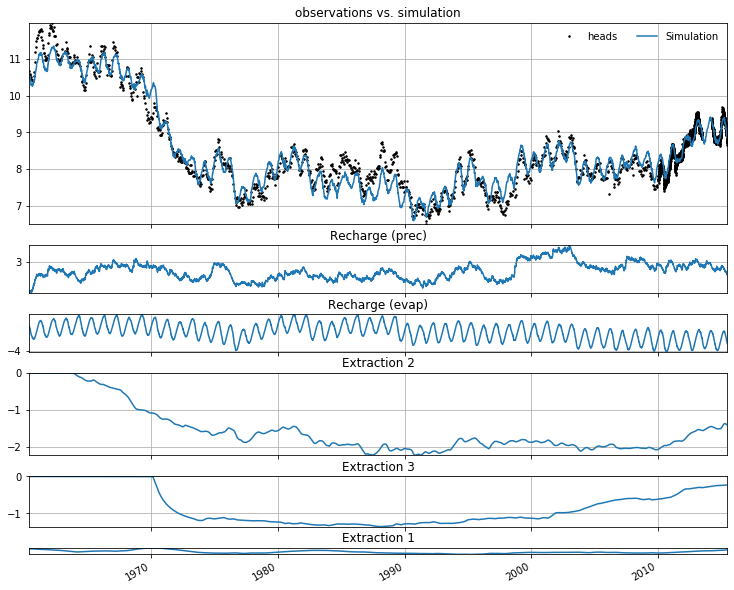

In [11]:
ml.plots.decomposition()

Plot the stacked influence of each of the individual extraction wells in the results plot

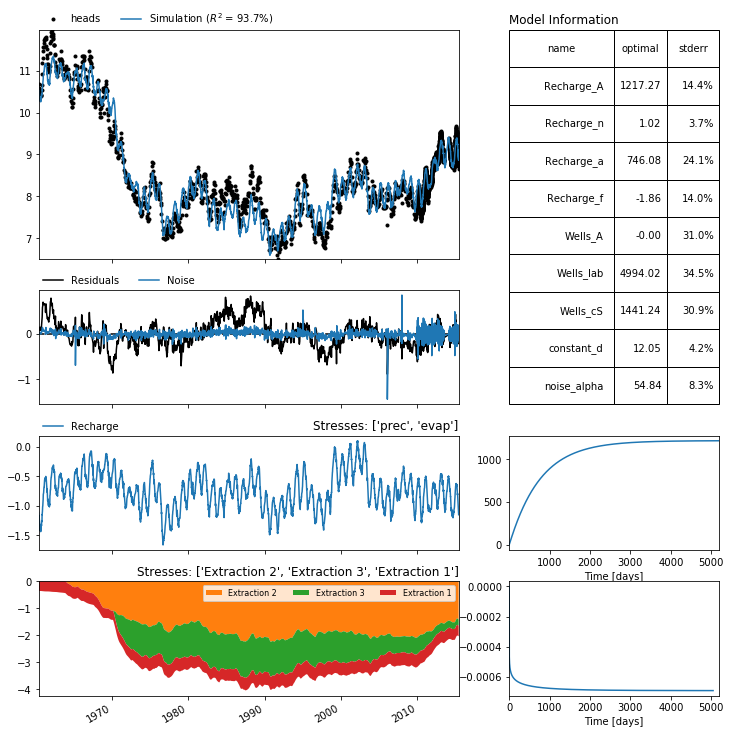

In [12]:
axes = ml.plots.stacked_results(figsize=(10, 10))

Get parameters for each well (including the distance) and calculate the gain:

In [13]:
wm = ml.stressmodels["Wells"]
for i in range(3):
    name = wm.stress[i].name
    p = wm.get_parameters(model=ml, istress=i)
    gain = wm.rfunc.gain(p) * 1e4
    print("{0}: gain = {1:.2f} m / 1e4 m^3/d".format(name, gain))

Extraction 2: gain = -0.80 m / 1e4 m^3/d
Extraction 3: gain = -0.67 m / 1e4 m^3/d
Extraction 1: gain = -0.33 m / 1e4 m^3/d
